In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import methods as m
import pickle
import warnings
import plotly as py
import os

warnings.filterwarnings('ignore')

In [23]:
def get_list_videos(vid_dir):
    f = []
    for (dirpath, dirnames, filenames) in os.walk(vid_dir):
        f.extend(filenames)
    return f


def run_openpose(vid_dir,coord_location, openpose_location):
    os.chdir(openpose_location)
    for video in get_list_videos(vid_dir):
        os.system(r'bin\OpenPoseDemo.exe --video "{0}\{1}" --write_json "{2}\{1}"'.format(vid_dir, video, coord_location))

        
def create_total_feature_df(coord_df, video_number, return_df):
    feature_df = to_feature_df(coord_df, video_number)
    if return_df is None:
        return_df = feature_df
        print(return_df)
    else:
        return_df = return_df.append(feature_df)
    return return_df


def to_feature_df(coord_df, video_number):
    """
    Gets a DataFrame of coordinates and turns this into features.
    In this case, the standard deviation of movement vertically. Extension to also horizontally can be easily made in case this helps for discovering speed.

    :param coord_df: A dataframe containing all relevant coördiantes observed in the video.

    :return features_df: returns a dataframe containing standard deviations of all observed coordinates
    """
    
    #Set video number
    coord_df['video'] = video_number
    
    #extract basic std deviation features of all joints
    feature_df = coord_df.pivot_table(index=['video', 'Fragment'], columns='Point', values='y', aggfunc=np.std)
  
    #set video index
    feature_df['video'] = feature_df.index

    #Add value representing how much (in absoluut values) someone leaned forward
    feature_df['Forward_leaning'] = forward_leaning(coord_df)


    return feature_df

def forward_leaning(coord_df):
    """
    Create forward leaning feature to be used in classification. The forward leaning feature discribes to what extent a person
    leans forward. which could be an indicator of a good runner

    :param coord_df:  A dataframe containing all relevant coördiantes observed in the video.
    :return return_list: returns a list containing containing the absoluut distance that is leaned forward
    """
    fragments = set(coord_df.Fragment)
    return_list = []

    for i in range(len(fragments)):
        fragment_df = coord_df[coord_df['Fragment'] == i+1]
        shoulder_df = fragment_df[fragment_df['Point'] == 'Right Shoulder']
        hip_df = fragment_df[fragment_df['Point'] == 'Right Hip']
        frames = set(fragment_df.Frame)
        temp_sum = 0
        frame_count = 0
        for j in range(len(frames)):
            difference = shoulder_df.iloc[j, 3] - hip_df.iloc[j, 3]
            #couldn't think of a smarter way to not take the nan values into account for the average
            if difference > 1:
                frame_count += 1
                temp_sum += difference
            if difference < -1:
                frame_count += 1
                temp_sum += difference
        return_list.append(abs(temp_sum / frame_count))
    return return_list

Point            Left Ear  Left Elbow   Left Eye  Left Foot  Left Hand  \
video Fragment                                                           
1     1          3.488845    7.772800   5.809978  14.222550  16.471086   
      2               NaN   15.314716  14.211519  18.417353  23.844098   
      3          4.428162    8.035262   5.682249  14.159308  18.413666   
      4         22.951053   18.205461  17.394667  17.556242  21.234743   

Point            Left Hip  Left Knee  Left Shoulder       Neck       Nose  \
video Fragment                                                              
1     1          5.894310   9.753233       3.075286   4.060106   3.431971   
      2         11.233644  12.282008      12.000584  12.159440  13.091858   
      3          5.209339   8.119560       3.323873   5.382658   3.860482   
      4         12.870366  12.772206      16.589518  15.144285  19.540199   

Point           Right Ear  Right Elbow  Right Eye  Right Foot  Right Hand  \
video Fragment 

Point            Left Ear  Left Elbow   Left Eye  Left Foot  Left Hand  \
video Fragment                                                           
1     1          3.488845    7.772800   5.809978  14.222550  16.471086   
      2               NaN   15.314716  14.211519  18.417353  23.844098   
      3          4.428162    8.035262   5.682249  14.159308  18.413666   
      4         22.951053   18.205461  17.394667  17.556242  21.234743   
2     1          4.271464   11.165543   4.090659  11.833713  20.304133   
      2         10.056814   10.209263   5.504886  13.635062  15.001313   
      3          2.946364    8.974509   3.190483  10.429726  16.224359   
      4         14.627026   15.022792  11.058203  16.369969  15.995893   

Point            Left Hip  Left Knee  Left Shoulder       Neck       Nose  \
video Fragment                                                              
1     1          5.894310   9.753233       3.075286   4.060106   3.431971   
      2         11.233644  12.282008      12.000584  12.159440  13.091858   
      3          5.209339   8.119560       3.323873   5.382658   3.860482   
      4         12.870366  12.772206      16.589518  15.144285  19.540199   
2     1         10.517099   7.282986       9.377957   8.061229   5.049741   
      2          4.137613   9.420587       5.854651   4.024850  10.911984   
      3          7.689904   6.075457       5.907272   6.669169   4.210865   
      4         10.036083  10.370919      10.765018   8.728439  12.258119   

Point           Right Ear  Right Elbow  Right Eye  Right Foot  Right Hand  \
video Fragment                                                              
1     1               NaN     9.444468   7.932669   11.762281   16.024264   
      2         11.556373     9.759669  13.792994    9.859048   18.600871   
      3          8.051909     8.827333   8.659836   14.420096   14.064968   
      4         17.368946    13.157493  18.118918   15.173883   18.279532   
2     1          2.414701    10.957376   5.535027   10.637598   16.679996   
      2          8.814414     8.059201   9.861400    8.388898   17.825105   
      3          3.763203     9.857222   2.568810   11.195304   14.878816   
      4         10.791705     9.381828  11.943265   11.003446   14.119136   

Point           Right Hip  Right Knee  Right Shoulder   video  Forward_leaning  
video Fragment                                                                  
1     1          5.870033    9.674037        5.242254  (1, 1)        17.946957  
      2          9.740232   11.220236       10.895896  (1, 2)        20.905741  
      3          5.167275    8.382881        6.556556  (1, 3)        21.280690  
      4         11.700039   12.269493       14.658505  (1, 4)        16.418605  
2     1          9.715550    5.933369        8.474044  (2, 1)        21.606596  
      2          3.018877    8.232384        3.647213  (2, 2)        14.988857  
      3          8.684353    4.230507        7.902058  (2, 3)        18.409630  
      4          8.197130    9.913921        8.817268  (2, 4)        13.853767

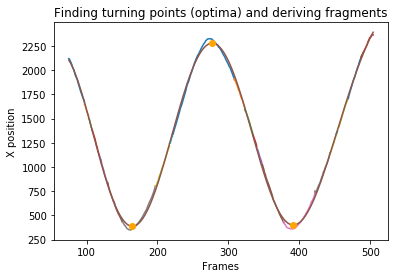

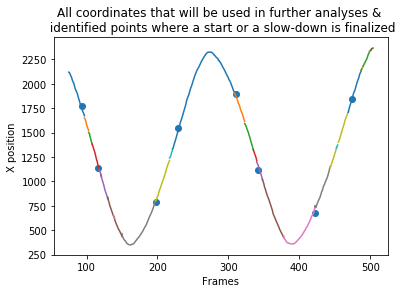

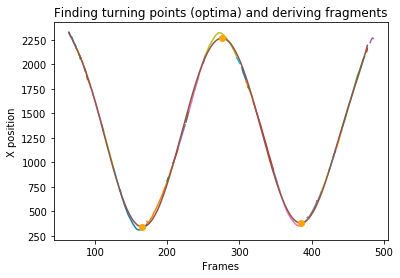

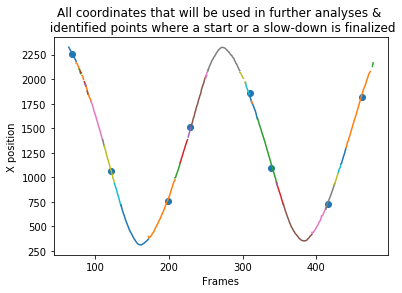

In [24]:
def prepare_data_for_classification(vid_dir,coord_location, openpose_location):
    #run_openpose(vid_dir,coord_location, openpose_location)
    video_number = 1
    return_df = None
    for video in get_list_videos(vid_dir):
        image_h, image_w, fps = m.determine_video_meta_data(r'{}\{}'.format(vid_dir, video))

        
#        people_per_file = m.get_openpose_output(r'{}\{}'.format(coord_location,video))
        period_person_division = m.get_period_person_division(m.get_openpose_output(r'{}\{}'.format(coord_location,video)), fps)
        person_period_division = m.get_person_period_division(period_person_division)
        
        mean_x_per_person = m.get_mean_x_per_person(person_period_division)
        
        normalized_moved_distance_per_person = m.normalize_moved_distance_per_person(mean_x_per_person)
        maximum_normalized_distance = max(normalized_moved_distance_per_person.values())
        
        movement_threshold = maximum_normalized_distance / 4
        
        moving_people = [key for key, value in normalized_moved_distance_per_person.items() if value > movement_threshold]
        
        
        person_plottables_df = m.get_person_plottables_df(mean_x_per_person, moving_people)
        
        dbscan_subsets = m.get_dbscan_subsets(maximum_normalized_distance, person_plottables_df)
        max_dbscan_subset = dbscan_subsets[
            np.argmax([sum([len(person_period_division[person]) for person in subset]) for subset in dbscan_subsets])]
        
        plottable_people = m.determine_plottable_people(person_plottables_df, 
                                                      max_dbscan_subset, 
                                                      maximum_normalized_distance*4)
        running_fragments, turning_fragments, fragments = m.get_running_and_turning_fragments(plottable_people, 
                                                                                                    mean_x_per_person, 
                                                                                                    person_plottables_df, 
                                                                                                    moving_people)
        
      #  coord_list = m.prepare_data_for_plotting(period_person_division, plottable_people, running_fragments)
        coord_df = m.get_dataframe_from_coords(m.prepare_data_for_plotting(period_person_division, 
                                                                           plottable_people, 
                                                                           running_fragments))
        return_df = create_total_feature_df(coord_df, video_number, return_df)

        video_number +=1
    return return_df
    
    
        
# extract_features(r'F:\Dropbox\TUe\DS-E\2017-2018\JM0130 Data Entrepreneurship in Action II\4. 2D_pose_estimation\videos',
#              r'F:\Dropbox\TUe\DS-E\2017-2018\JM0130 Data Entrepreneurship in Action II\4. 2D_pose_estimation\coordinates',
#             r'C:\Users\Herbert van Leeuwen\Desktop\openpose-1.2.1-win64-binaries\openpose-1.2.1-win64-binaries')

prepare_data_for_classification(r'C:\Users\herbe\Dropbox\TUe\DS-E\2017-2018\JM0130 Data Entrepreneurship in Action II\4. 2D_pose_estimation\videos',
             r'C:\Users\herbe\Dropbox\TUe\DS-E\2017-2018\JM0130 Data Entrepreneurship in Action II\4. 2D_pose_estimation\coordinates',
            r'C:\Users\Herbert van Leeuwen\Desktop\openpose-1.2.1-win64-binaries\openpose-1.2.1-win64-binaries')